### Data preparation

We will prepare the suggested data, grouping them into one table in
 preparation for clustering process

Since we are dealing with Highland Coffee, we will limit the dataset to Highland coffee only

To carry out clustering and segmentation, we need to compile a clean dataset, here are some criteria we based on to construct such table:
- the table should holistically describe our customers' persona:
  + Demographic: Age, MPI_Mean_use, Occupation group
  + Psychology (need): Needstate#group
  + Perception: NPS#P3M, Comprehension
  + Behavior: Fre#Visit, PPA, Spending, Companion

- the columns list above ensure that the data is holistic, covering all possible types of customers visiting Highlands, while also reducing the complexity of the data.
- For example, instead of using Occupation, we use Occupation#Group. The latter contains fewer but still holistic items.
- Also, this reduced complexity helps fasten the model without sacrificing accuracy.

Next we will transform the data:
- Delete NaN:
  + we have tested with filling using median, KNN imputation (we have shortened our work by not including median and KNN imputation fill in this work)
  + and the result returns unfavorable cluster. So we decided to **drop all nulls**
- We also check for outliers to delete promptly outlying values that could weaken prediction ability of our model
- We do one-hot encoding to turn category into calculable numeric form.

In [ ]:
# Limit brand health survey to "Highland Coffee"
# We choose bhealth because this has the most thorough list of ID
# Also, bhealth has column Brand, making filtering easy

# unique ID
bhealth_highland = df_bhealth[df_bhealth['Brand']=='Highlands Coffee']
bhealth_highland = bhealth_highland[['ID',
                                    'Comprehension',
                                     'Fre#visit',
                                     'Spending',
                                     'PPA',
                                     'NPS#P3M']]
# Limit the other required tables
a = bhealth_highland['ID'].unique()

# transform the other required table

# Non_unique ID
companion_highland = df_companion[df_companion['ID'].isin(a)]
companion_highland = companion_highland[['ID',
                                         'Companion#group']]

# Non_unique ID
need_highland = df_need[df_need['ID'].isin(a)]
need_highland = need_highland[['ID',
                               'NeedstateGroup']]

# Unique ID
demo_highland = df_demographic[df_demographic['ID'].isin(a)]
demo_highland = demo_highland[['ID',
                               'Age',
                               'MPI_Mean_Use',
                               'Occupation#group']]

We carry out one-hot encoding before dealing with NaN

- One hot encoding for Non_unique Ids

In [ ]:
# Companion
companion_highland = pd.get_dummies(companion_highland, columns=['Companion#group'], dtype=int)
companion_highland = companion_highland.groupby('ID').max().reset_index()

# Needstate
need_highland = pd.get_dummies(need_highland, columns=['NeedstateGroup'], dtype=int)
need_highland = need_highland.groupby('ID').max().reset_index()

- One hot encoding for tables with Unique IDs

In [ ]:
# Preprocessing for bhealth

# For comprehension we would change "Unanswered", "Maybe do not know it", and "Do not know it at all"
# as "Do not know it"
# Because:
# We are conservative in our prediction, so we assume Unanswered as Do not know about it. This conservatism helps Highland to be cautious in business
# Also, standardize "do not know it" can simplify the model as "Maybe do not know it", and "Do not know it at all" both reflects ignorance.

bhealth_highland['Comprehension'] = bhealth_highland['Comprehension'].apply(
                                    lambda x: 'Do not know it'
                                    if x in ['Unanswered', 'Maybe do not know it', 'Do not know it at all']
                                    else x)


In [ ]:
# bhealth
bhealth_highland = pd.get_dummies(bhealth_highland,
                                  columns=['Comprehension'],
                                  dtype=int)


# demographic
demo_highland = pd.get_dummies(demo_highland,
                               columns=['Occupation#group'],
                               dtype=int)

Merge all tables into 1

In [ ]:
# Merging on ID using left join
df_master = demo_highland.merge(bhealth_highland, on='ID', how='left')
df_master = df_master.merge(companion_highland, on='ID', how='left')
df_master = df_master.merge(need_highland, on='ID', how='left')

In [ ]:
# Make sure PPA = Spend/Visit
df_master['PPA'] = df_master['Spending']/df_master['Fre#visit']

Drop all other missing values due to small number

In [ ]:
df_master.dropna(inplace=True)

Outlier

<Axes: xlabel='Spending', ylabel='MPI_Mean_Use'>

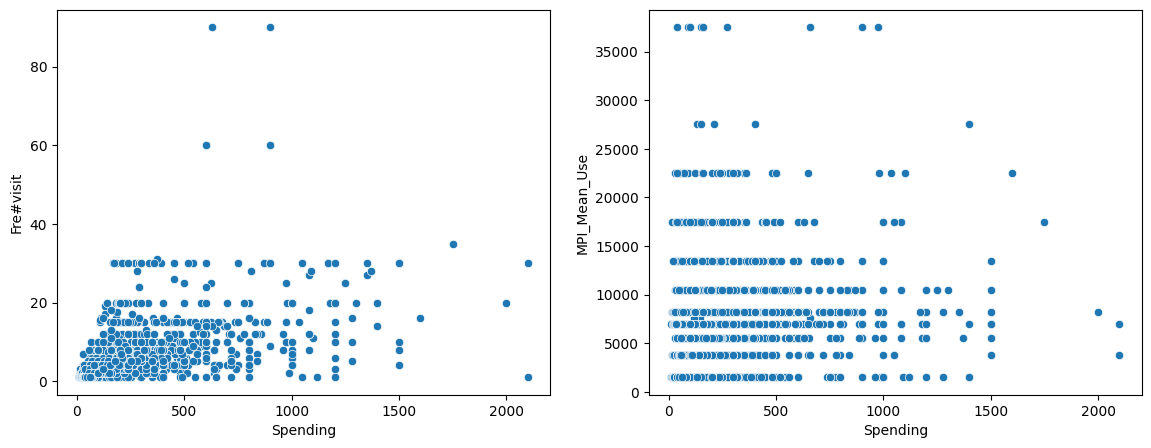

In [ ]:
# Check outlier for MPI_Mean_Use and Spending
import seaborn as sns
import matplotlib.pyplot as plt
fig, axe = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(data = df_master, x = 'Spending', y = 'Fre#visit', ax = axe[0])
sns.scatterplot(data = df_master, x = 'Spending', y = 'MPI_Mean_Use', ax = axe[1])

In [ ]:
# Drop outlier
df_master = df_master[(df_master['Spending'] < 1510) &
                      (df_master['MPI_Mean_Use'] < 40000) &
                      (df_master['Fre#visit'] < 40)]

### Customer segmentation

In [ ]:
df_input_use_later = df_master.copy()

# Data Standardization
df_input = df_master.drop(columns = 'ID')
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_master_scaled = pd.DataFrame(
    scaler.fit_transform(df_input),
    columns=df_input.columns,
    index=df_input.index
)

Next, we will choose model and optimal K at the same time
- Here we test 4 models: Agglomerative, Kmeans, DBSCAN, Gaussin (GMM)

We use Davis_bourdan and Sihouette score to evaluate the best number of cluster
- Davis-bourdan will tell us how tight the cluster: How far each point to the center, the smaller the better.
- Silhouette score tell us how far each cluster is to the other clusters. This help us avoid meaningless clusters. For example, if two clusters are so close, they should be grouped into 1 cluster only.

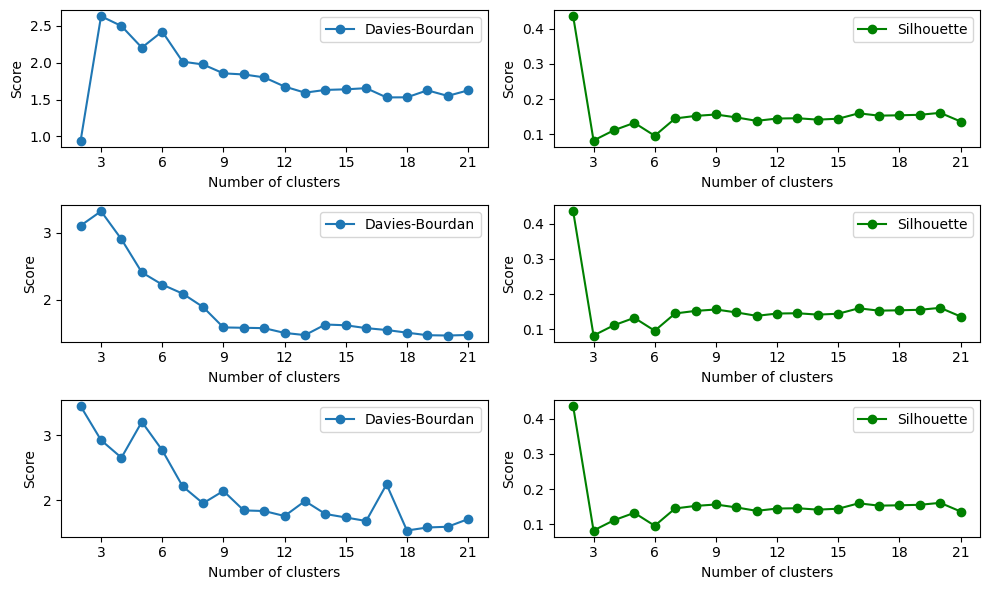

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import numpy as np

davi = []
silhouette = []

daviagg = []
silhouetteagg = []

davigaus = []
silogaus = []


for k in range(2,22):
  # Kmeans
  # Davi
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(df_master_scaled)
  davi_bour = davies_bouldin_score(df_master_scaled, kmeans.labels_)
  davi.append(davi_bour)
  # Silhouette score
  labels = kmeans.labels_
  silhouette_avg = silhouette_score(df_master_scaled, labels)
  silhouette.append(silhouette_avg)

  # Agglomeratative
  # Davi
  aggmeans = AgglomerativeClustering(n_clusters=k)
  aggmeans.fit(df_master_scaled)
  davi_bour2 = davies_bouldin_score(df_master_scaled, aggmeans.labels_)
  daviagg.append(davi_bour2)
  # Silhouette score
  labels2 = aggmeans.labels_
  silhouette_avg2 = silhouette_score(df_master_scaled, labels)
  silhouetteagg.append(silhouette_avg2)

  # Gaussin
  # Davi
  gaumeans = GaussianMixture(n_components=k)
  gaumeans.fit(df_master_scaled)
  davi_bour3 = davies_bouldin_score(df_master_scaled, gaumeans.predict(df_master_scaled))
  davigaus.append(davi_bour3)
  # Silhouette score
  labels2 = aggmeans.labels_
  silhouette_avg3 = silhouette_score(df_master_scaled, labels)
  silogaus.append(silhouette_avg3)

# Plot both score into a line chart
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
fig, axe = plt.subplots(3, 2, figsize=(10, 6))  # 3 rows, 2 column

axe[0,0].plot(range(2, 22), davi, label='Davies-Bourdan', marker='o')
axe[0,0].set_xlabel('Number of clusters')
axe[0,0].set_ylabel('Score')
axe[0,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axe[0,0].legend()

axe[0,1].plot(range(2, 22), silhouette, label='Silhouette', marker='o', color='green')
axe[0,1].set_xlabel('Number of clusters')
axe[0,1].set_ylabel('Score')
axe[0,1].xaxis.set_major_locator(MaxNLocator(integer=True))
axe[0,1].legend()

axe[1,0].plot(range(2, 22), daviagg, label='Davies-Bourdan', marker='o')
axe[1,0].set_xlabel('Number of clusters')
axe[1,0].set_ylabel('Score')
axe[1,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axe[1,0].legend()

axe[1,1].plot(range(2, 22), silhouetteagg, label='Silhouette', marker='o', color='green')
axe[1,1].set_xlabel('Number of clusters')
axe[1,1].set_ylabel('Score')
axe[1,1].xaxis.set_major_locator(MaxNLocator(integer=True))
axe[1,1].legend()

axe[2,0].plot(range(2, 22), davigaus, label='Davies-Bourdan', marker='o')
axe[2,0].set_xlabel('Number of clusters')
axe[2,0].set_ylabel('Score')
axe[2,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axe[2,0].legend()

axe[2,1].plot(range(2, 22), silogaus, label='Silhouette', marker='o', color='green')
axe[2,1].set_xlabel('Number of clusters')
axe[2,1].set_ylabel('Score')
axe[2,1].xaxis.set_major_locator(MaxNLocator(integer=True))
axe[2,1].legend()

plt.tight_layout()
plt.show()

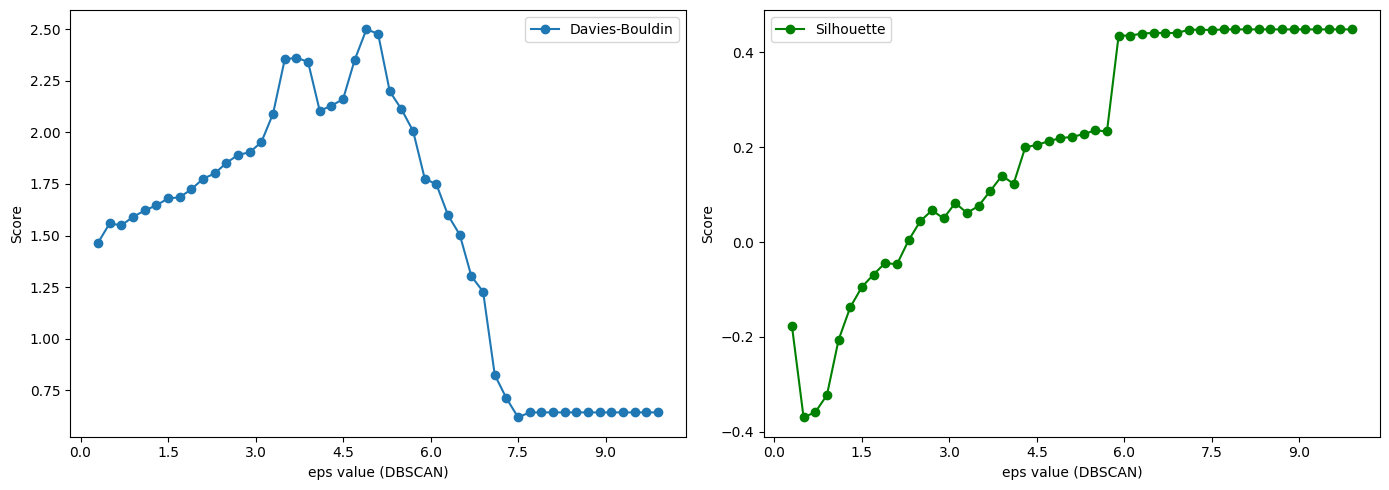

Number of clusters formed: 5
Cluster_DBSCAN
 0    3465
 2      38
 1      14
 3       8
 4       5
-1       1
Name: count, dtype: int64


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

# Initialize lists
davi = []
silhouette = []
eps_values = np.arange(0.1, 10, 0.2)  # range of eps to try

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(df_master_scaled)

    # Skip if only one cluster or all points are noise
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters <= 1:
        davi.append(np.nan)
        silhouette.append(np.nan)
        continue

    # Davies-Bouldin
    davi_bour = davies_bouldin_score(df_master_scaled, labels)
    davi.append(davi_bour)

    # Silhouette
    silhouette_avg = silhouette_score(df_master_scaled, labels)
    silhouette.append(silhouette_avg)

# Plot
fig, axe = plt.subplots(1, 2, figsize=(14, 5))

axe[0].plot(eps_values, davi, label='Davies-Bouldin', marker='o')
axe[0].set_xlabel('eps value (DBSCAN)')
axe[0].set_ylabel('Score')
axe[0].xaxis.set_major_locator(MaxNLocator(integer=False))
axe[0].legend()

axe[1].plot(eps_values, silhouette, label='Silhouette', marker='o', color='green')
axe[1].set_xlabel('eps value (DBSCAN)')
axe[1].set_ylabel('Score')
axe[1].xaxis.set_major_locator(MaxNLocator(integer=False))
axe[1].legend()

plt.tight_layout()
plt.show()

from sklearn.cluster import DBSCAN

# Fit DBSCAN with the chosen eps
dbscan = DBSCAN(eps=7.5, min_samples=5)
labels = dbscan.fit_predict(df_master_scaled)

# Attach labels to your original DataFrame
df_master['Cluster_DBSCAN'] = labels

# Optional: Check how many clusters were formed
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters formed: {n_clusters}")
print(df_master['Cluster_DBSCAN'].value_counts())


Final decision:
- 2 cluster: This is small enough cluster, make analysis simple
- Kmeans work best with silhouette nearly 50% (acceptable range) and Davis lowest among the 3 models
- For DBSCAN, which can hardly be compared. However, we still not choose it because the segments divided are uneven (0: 3465, nearly all the data)


Run the model plus visualization

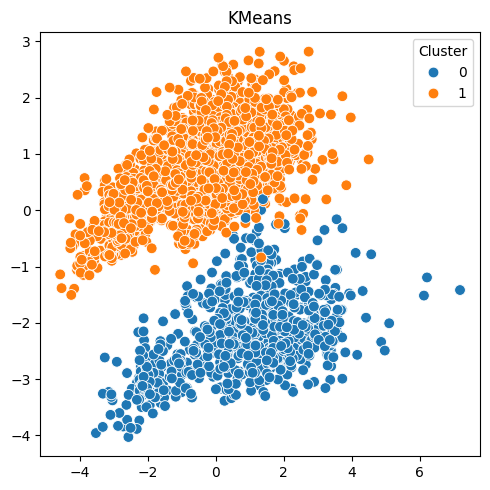

In [ ]:
# KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Step 1: Apply Kmeans
n_clusters = 2
model = KMeans(n_clusters=n_clusters, random_state = 4)
cluster_labels = model.fit_predict(df_master_scaled)

# --- Step 2: Add cluster labels to DataFrame
df_clusters = pd.DataFrame(df_master_scaled, columns=[f"feature_{i}" for i in range(df_master_scaled.shape[1])])
df_clusters['Cluster'] = cluster_labels

# --- Step 3: Visualize clusters using PCA ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_master_scaled)

plt.figure(figsize=(5,5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='tab10', s=60)
plt.title('KMeans')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()